In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from mnist_dataset import Dataset

import matplotlib.pyplot as plt

In [28]:
class RGAN:
    
    def __init__(self, x_size, z_size):
        self.x_size = x_size
        self.z_size = z_size
        
        self.__build()
    
    def __build(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.__placeholders()
            
            # generator
            g_outputs, g_model = self.__get_generator(self.z)
            # discriminator
            real_outputs, real_logits = self.__get_discriminator(self.X)
            fake_outputs, fake_logits = self.__get_discriminator(g_model, True)
            
            # LOSSES
            self.loss_disc = -tf.reduce_mean(tf.log_sigmoid(real_logits - fake_logits))
            self.loss_gen = -tf.reduce_mean(tf.log_sigmoid(fake_logits - real_logits))
            
            # OPTIMIZER
            t_vars = tf.trainable_variables()
            d_vars = [var for var in t_vars if 'disc' in var.name]
            g_vars = [var for var in t_vars if 'gen' in var.name]
            
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                self.opt_disc = tf.train.AdamOptimizer(self.eta, .5).minimize(self.loss_disc, var_list=d_vars)
                self.opt_gen = tf.train.AdamOptimizer(self.eta, .5).minimize(self.loss_gen, var_list=g_vars)
            
            self.generator, _ = self.__get_generator(self.z, True)
    
    def __placeholders(self):
        self.X = tf.placeholder(tf.float32, (None, *self.x_size), name='X')
        self.z = tf.placeholder(tf.float32, [None, self.z_size], name='z')
        
        self.eta = tf.placeholder(tf.float32, name='eta')
        self.is_training = tf.placeholder(tf.bool, name='is_training')
    
    def __get_generator(self, tensor, reuse=False):
        with tf.variable_scope('gen', reuse=reuse):
            tensor = tf.layers.dense(tensor, 7*7*128)
            tensor = tf.reshape(tensor, (-1, 7, 7, 128))
            tensor = tf.layers.batch_normalization(tensor, training=self.is_training)
            tensor = tf.nn.tanh(tensor)
            
            tensor = tf.layers.conv2d_transpose(tensor, 64, 5, strides=2, padding='same')
            tensor = tf.layers.batch_normalization(tensor, training=self.is_training)
            tensor = tf.nn.tanh(tensor)
            
            tensor = tf.layers.conv2d_transpose(tensor,  1, 5, strides=2, padding='same')

        return tf.nn.sigmoid(tensor), tensor
    
    def __get_discriminator(self, tensor, reuse=False):
        with tf.variable_scope('disc', reuse=reuse):
            tensor = self.__add_noise(tensor, std=.5)
            tensor = tf.layers.conv2d(tensor,  64, 5, 2, 'same', activation=tf.nn.relu)

            tensor = self.__add_noise(tensor, std=.3)
            tensor = tf.layers.conv2d(tensor, 128, 5, 2, 'same', activation=tf.nn.relu)
            
            tensor = tf.layers.flatten(tensor)
            tensor = tf.layers.dense(tensor, 1)
        return tf.nn.sigmoid(tensor), tensor
    
    def __add_noise(self, tensor, mu=0., std=1.):
        noise = tf.random_normal(tf.shape(tensor), mu, std)
        return tensor + noise

model = RGAN([28, 28, 1], 100)

In [9]:
dataset = Dataset('./mnist_dataset/')

In [35]:
model = RGAN([28, 28, 1], 100)
model_name = 'mnist_rgan'

epochs = 20
batch_size = 100
train_size = len(dataset.train['images'])

with tf.Session(graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, f'./models/{model_name}')
    
    for epoch in range(epochs):
        d_losses, g_losses = list(), list()
        for _ in range(train_size//batch_size):
            X, _ = dataset.next_batch(batch_size)
            
            feed_dict = dict()
            feed_dict[model.X] = X.reshape(-1, 28, 28, 1)
            feed_dict[model.z] = np.random.randn(batch_size, model.z_size)
            feed_dict[model.eta] = 1e-3
            feed_dict[model.is_training] = True
            
            d_loss, _ = sess.run([model.loss_disc, model.opt_disc], feed_dict)
            
            X, _ = dataset.next_batch(batch_size)
            feed_dict[model.X] = X.reshape(-1, 28, 28, 1)
            feed_dict[model.z] = np.random.randn(batch_size, model.z_size)
            
            g_loss, _ = sess.run([model.loss_gen, model.opt_gen], feed_dict)
            d_losses.append(d_loss); g_losses.append(g_loss);
            print(f'\rEpoch: {epoch+1:3}/{epochs:3} - DLoss: {d_loss:.6f} - GLoss: {g_loss:.6f}', end='')
        d_loss = np.mean(d_losses)
        g_loss = np.mean(g_losses)
        print(f'\rEpoch: {epoch+1:3}/{epochs:3} - DLoss: {d_loss:.6f} - GLoss: {g_loss:.6f}')
    
    saver.save(sess, f'./models/{model_name}')

INFO:tensorflow:Restoring parameters from ./models/mnist_rgan
Epoch:   1/ 20 - DLoss: 0.463274 - GLoss: 2.402705
Epoch:   2/ 20 - DLoss: 0.430690 - GLoss: 2.535681
Epoch:   3/ 20 - DLoss: 0.423827 - GLoss: 2.606667
Epoch:   4/ 20 - DLoss: 0.414344 - GLoss: 2.621855
Epoch:   5/ 20 - DLoss: 0.414291 - GLoss: 2.614762
Epoch:   6/ 20 - DLoss: 0.414136 - GLoss: 2.526117
Epoch:   7/ 20 - DLoss: 0.415439 - GLoss: 2.466456
Epoch:   8/ 20 - DLoss: 0.420165 - GLoss: 2.397027
Epoch:   9/ 20 - DLoss: 0.417915 - GLoss: 2.416888
Epoch:  10/ 20 - DLoss: 0.419470 - GLoss: 2.362982
Epoch:  11/ 20 - DLoss: 0.417501 - GLoss: 2.359765
Epoch:  12/ 20 - DLoss: 0.427688 - GLoss: 2.266498
Epoch:  13/ 20 - DLoss: 0.428712 - GLoss: 2.262878
Epoch:  14/ 20 - DLoss: 0.431341 - GLoss: 2.257017
Epoch:  15/ 20 - DLoss: 0.436195 - GLoss: 2.188052
Epoch:  16/ 20 - DLoss: 0.435268 - GLoss: 2.202919
Epoch:  17/ 20 - DLoss: 0.446336 - GLoss: 2.143816
Epoch:  18/ 20 - DLoss: 0.448049 - GLoss: 2.120761
Epoch:  19/ 20 - DLo

INFO:tensorflow:Restoring parameters from ./models/mnist_rgan


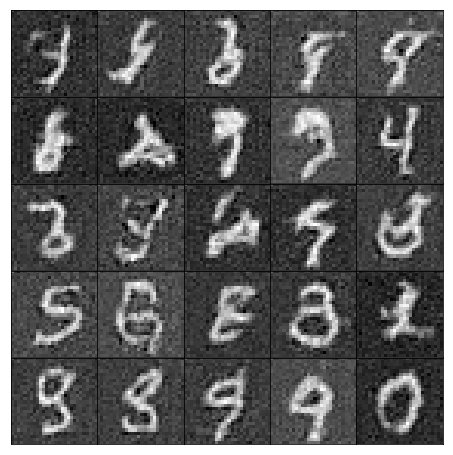

In [38]:
model = RGAN([28, 28, 1], 100)
model_name = 'mnist_rgan'

with tf.Session(graph=model.graph) as sess:    
    saver = tf.train.Saver()
    saver.restore(sess, f'./models/{model_name}')
    
    feed_dict = dict()
    feed_dict[model.z] = np.random.randn(25, model.z_size)
    feed_dict[model.is_training] = False
    
    imgs = sess.run(model.generator, feed_dict)

imgs = imgs.reshape(5,5,28,28)
f, axs = plt.subplots(5, 5, figsize=(12, 8), sharex=True, sharey=True)
f.subplots_adjust(wspace=0, hspace=.0, right=.5, left=0)

for i, cols in enumerate(axs):
    for j, ax in enumerate(cols):
        ax.imshow(imgs[i, j], 'gray')
        ax.set_xticks([])
        ax.set_yticks([])